In [1]:
import pandas_datareader.data as pdr
import datetime as dt
import pandas as pd
import numpy as np

def getdata(stock_list, days):
  df = pd.DataFrame()
  for tickers in stock_list:
    df[tickers] = pdr.DataReader(tickers, 'yahoo', start='1/1/2014')['Adj Close']
  return df.head(days)


/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def rsi(data):
  delta = data.diff()
  up, down = delta.copy(), delta.copy()
  up[up < 0] = 0
  down[down > 0] = 0
  
  roll_up = up.mean()
  roll_down = down.abs().mean()

  RS = roll_up / roll_down
  rsi = (100.0 - (100.0 / (1.0 + RS)))[0]
  
  if(rsi > 70): return -1,rsi
  elif(rsi < 30): return 1,rsi
  else: return 0,rsi

In [3]:
def macd(data):
  df = data.copy()
  malong = df.ewm(span = 26 , min_periods = 26).mean().tail(1).iloc[0,0]
  mashort = df.ewm(span = 12 , min_periods = 12).mean().tail(1).iloc[0,0]
  macD = mashort - malong
  if macD>0:
    #Buy Signal
    return 1
  elif macD==0:
    #Hold Signal
    return 0
  else:
    #Sell Signal
    return -1  

In [4]:
def ma(data, price):
  mavg = data.mean().values[0]
  if price>mavg:
    return 1
  elif price<mavg:
    return -1

In [5]:
def createbook(df, days, portfolio):
  tracker = pd.DataFrame(index = df.tail(days - 26).index, columns = ['Liquid Cash', 'Stock Value'])
  tracker['Stock Value'] = np.zeros(days - 26)
  tracker['Liquid Cash'] = np.zeros(days - 26)
  tracker['Liquid Cash'][0] = portfolio
  return tracker

In [6]:
days = 1500
portfolio = 500
signal1 = 0
bought = 0
data = getdata(['RELIANCE.NS'], days)
tracker = createbook(data, days, portfolio)
for index, rows in tracker.iterrows():
  signal1 = rsi(data.loc[:index].tail(14))[0]
  signal2 = macd(data.loc[:index].tail(26))
  signal3 = ma(data.loc[:index].tail(20), data.loc[index][0])
  leftover = tracker.loc[:index].tail(2).head(1).iloc[0,0]
  if (signal1==1 or signal2==1 or signal3==1) and bought==0:
    tracker.loc[index, 'Liquid Cash'] = leftover - data.loc[index][0]
    tracker.loc[index, 'Stock Value'] = data.loc[index][0]
    bought=1
  elif (signal3==-1) and bought==1:
    tracker.loc[index, 'Liquid Cash'] = leftover + data.loc[index][0]
    tracker.loc[index, 'Stock Value'] = 0
    bought=0
  elif bought==0:
    tracker.loc[index, 'Liquid Cash'] = leftover
    tracker.loc[index, 'Stock Value'] = 0
  elif bought==1:
    tracker.loc[index, 'Liquid Cash'] = leftover
    tracker.loc[index, 'Stock Value'] = data.loc[index][0]


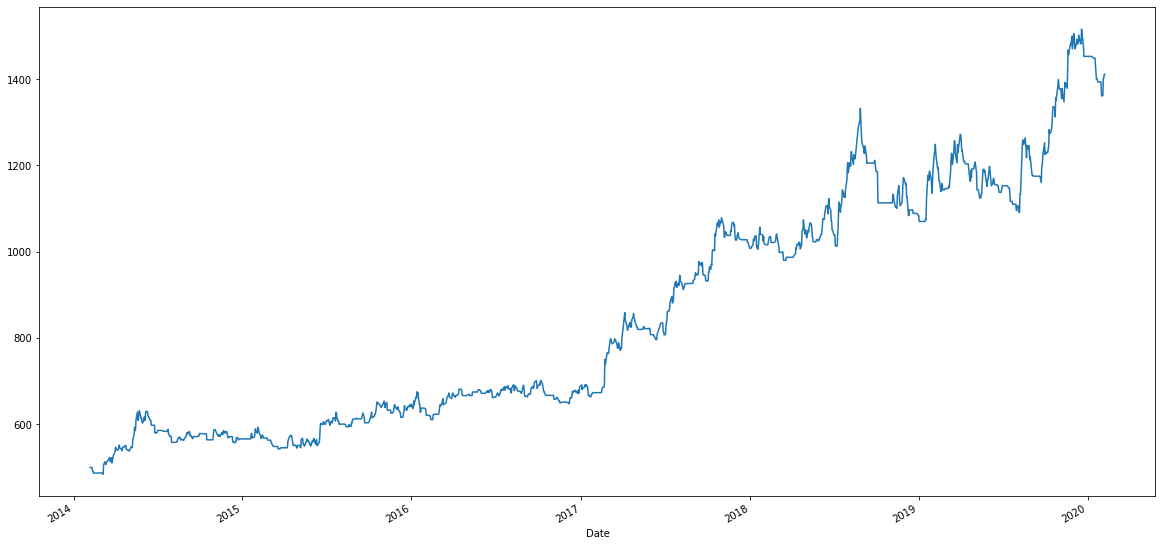

In [7]:
tracker['Net'] = tracker.sum(axis=1)
import matplotlib.pyplot as plt
tracker['Net'].plot(figsize=(20, 10))

# KPI Analyses

## CAGR

In [8]:
def cagr(data):
  df = data.copy()
  df = df.pct_change()
  df = (1+df).cumprod()
  n = len(df)/252
  r = df.tail(1).iloc[0,0]
  ret = ((r)**(1/n)) - 1
  return ret*100

In [9]:
check = pd.DataFrame(tracker['Net'])
cagr(check)

19.41581839588773

## Risk 

In [10]:
def volatility(data):
  import numpy as np
  df = data.copy()
  df = df.pct_change()
  risk = df.std()*np.sqrt(252)
  return risk*100

In [11]:
check = pd.DataFrame(tracker['Net'])
volatility(check)

Net    17.984457
dtype: float64

## Shape Ratio

In [12]:
def sharpe(data, rf = 5.42):
  df = data.copy()
  sratio = (cagr(df) - rf)/volatility(df)
  return sratio

In [13]:
check = pd.DataFrame(tracker['Net'])
sharpe(check)

Net    0.778217
dtype: float64

## Sortino's Ratio

In [14]:
def sortino(data, rf = 5.42):
  import numpy as np
  df = data.copy()
  cgr = cagr(df)
  df = df.pct_change()
  negvol = df[df<0].std()*np.sqrt(252)*100
  sortr = (cgr - rf)/negvol
  return sortr

In [15]:
check = pd.DataFrame(tracker['Net'])
sortino(check)

Net    1.097335
dtype: float64

## Maximum Drawdown

In [16]:
def maxdd(data):
  df = data.copy()
  df = df.pct_change()
  dfcp = (1+df).cumprod()
  dfm = dfcp.cummax()
  dfr = (dfm - dfcp)/dfm
  max_dd = dfr.max()
  return max_dd*100

In [17]:
check = pd.DataFrame(tracker['Net'])
maxdd(check)

Net    19.670954
dtype: float64

## Calmar Ratio

In [18]:
def calmar(data):
  df = data.copy()
  clmr = cagr(df)/maxdd(df)
  return clmr

In [19]:
check = pd.DataFrame(tracker['Net'])
calmar(check)

Net    0.98703
dtype: float64